In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax
from jax.scipy.special import logsumexp

import context

from examples.PMF.pmf_model import grad_log_post
from examples.PMF.util import R_train, R_test, flatten_PMF_params, load_PMF_MAP, get_rmse_list, mean_rating
from examples.PMF.sgld_PMF_functions import sgld_PMF_time_budget_CV, sgld_PMF_time_budget, sgld_PMF_time_budget_svrg
from examples.PMF.adam import sgld_adam_PMF_time_budget
from examples.PMF.sghmc import run_sghmc_PMF, run_sghmc_PMF_time_budget


from ksd import imq_KSD
from util import progress_bar_scan, wait_until_computed

# PMF - uncertainty tests

Compare posterior variance to NUTS

Compare posterior standard deviation relative errors:

sgld:
- SH: 0.3652
- default: 1.0870
- adam: 0.3747

svrg:
- SH: 0.468
- default: 0.352

sghmc:
- SH: 0.401
- default: 0.557

Number of samples:

sgld:
- 147,120
- 98,910
- 88,590

svrg:
- 85,800
- 

sghmc:
- 34,290
- 5,140

In [38]:
print("std relative errors:\n")
print("sgld:")
print(f"SH: {std_error_sgld_SH:.4f}")
print(f"default: {std_error_sgld_default:.4f}")
print(f"adam: {std_error_sgld_adam:.4f}")

print("\nsvrg:")
print(f"SH: {std_error_svrg_SH:.3f}")
print(f"default: {std_error_svrg_default:.3f}")


print("\nsghmc:")
print(f"SH: {std_error_sghmc_SH:.3f}")
print(f"default: {std_error_sghmc_default:.3f}")


std relative errors:

sgld:
SH: 0.3652
default: 1.0870
adam: 0.3747

svrg:
SH: 0.468
default: 0.352

sghmc:
SH: 0.401
default: 0.557


In [12]:
from config import BASE_DIR

def load_PMF_NUTS_stds():
    return [np.genfromtxt(f"{BASE_DIR}/data/PMF_NUTS_stds/PMF_{idx}_std.txt") for idx in range(6)]


numpyro_stds = load_PMF_NUTS_stds()


def get_relative_error(samples, numpyro_stds=numpyro_stds):
    flat_samples = flatten_PMF_params(samples)
    flat_samples_std = flat_samples.std(axis=0)
    flat_numpyro_std = flatten_PMF_params([numpyro_stds])[0]
    return np.linalg.norm(flat_samples_std-flat_numpyro_std)/np.linalg.norm(flat_numpyro_std)
    
    

# sgld

#### 1. SH

In [6]:
key = random.PRNGKey(0)
MAP_params = load_PMF_MAP()

# use parameters from the 1st SH chain (from list_params_sgld_10`)
dt = 10**(-4.41)
batch_size = int(0.0046*R_train.shape[0])
time_budget = 400.

samples_SH, _ = sgld_PMF_time_budget(key, time_budget, grad_log_post, dt, batch_size, MAP_params, R_train, save_rate=30)

print(f"Number of samples: {len(samples_SH)*30:,}")

Number of samples: 300,420


In [7]:
flat_samples = flatten_PMF_params(samples_SH)
flat_samples_std = flat_samples.std(axis=0)



In [13]:
std_error_sgld_SH = get_relative_error(samples_SH)
print(std_error_sgld_SH)

In [14]:
print(std_error_sgld_SH)

0.36515895


In [4]:

# rmse_list_sgld_SH = get_rmse_list(samples_SH, R_test, mean_rating)

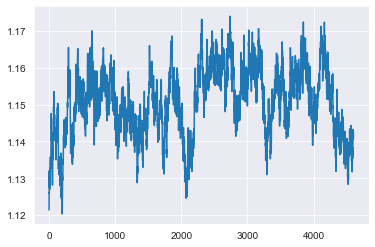

In [10]:
burnin_sgld_SH = 300

plt.plot(rmse_list_sgld_SH[burnin_sgld_SH:])

In [26]:
# np.savetxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_SH.txt", rmse_list_sgld_SH)

rmse_list_sgld_SH = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_SH.txt")

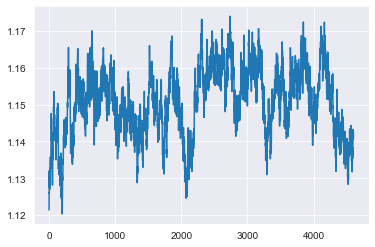

In [52]:
burnin_sgld_SH = 300

plt.plot(rmse_list_sgld_SH[burnin_sgld_SH:])

In [53]:
# samples_std_SH = []
# for idx in range(6):
#     samples_std_SH.append(np.std([elem[idx] for elem in samples_SH[burnin_sgld_SH:]], axis=0))
    
# list_rel_error_SH = []
# for idx in range(6):
#         list_rel_error_SH.append(np.linalg.norm(samples_std_SH[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

# mean_variance_error_SH = np.mean(list_rel_error_SH)
# print(mean_variance_error_SH)

0.518633284610348


##### 2. default

In [15]:
key = random.PRNGKey(0)
MAP_params = load_PMF_MAP()
dt = 10**(-3.3)
batch_size = int(0.1*R_train.shape[0])
time_budget = 400.

samples_default, _ = sgld_PMF_time_budget(key, time_budget, grad_log_post, 
                                dt, batch_size, MAP_params, R_train, save_rate=30)


print(f"Number of samples: {len(samples_default)*30:,}")

Number of samples: 184,920


In [16]:
std_error_sgld_default = get_relative_error(samples_default)
print(std_error_sgld_default)


1.0869966


In [54]:

# rmse_list_sgld_default = get_rmse_list(samples_default, R_test, mean_rating)

# plt.plot(rmse_list_sgld_default)

In [55]:
# np.savetxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_default.txt", rmse_list_sgld_default)

rmse_list_sgld_default = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_default.txt")


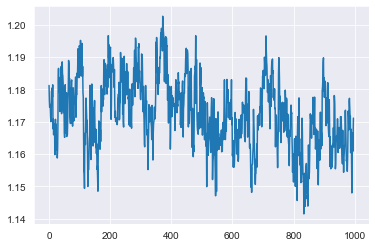

In [58]:
burnin_sgld_default = 2300

plt.plot(rmse_list_sgld_default[burnin_sgld_default:])

In [59]:
samples_std_default = []
for idx in range(6):
    samples_std_default.append(np.std([elem[idx] for elem in samples_default[burnin_sgld_default:]], axis=0))


list_rel_error_default = []
for idx in range(6):
        list_rel_error_default.append(np.linalg.norm(samples_std_default[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_default = np.mean(list_rel_error_default)

print(mean_variance_error_default)


0.5801330918673869


#### 3. sgld-adam

In [17]:
time_budget = 400.

key = random.PRNGKey(0)
dt = 1e-3
batch_size = int(R_train.shape[0]*0.1)
params_IC = load_PMF_MAP()
samples_sgldadam, _ = sgld_adam_PMF_time_budget(key, time_budget, dt, 
                                batch_size, R_train, params_IC, save_rate=30)

print(f"Number of samples: {len(samples_sgldadam)*30:,}")

Compiling
Running
Iteration 2000. Time: 4 / 400.0 sec
Iteration 4000. Time: 9 / 400.0 sec
Iteration 6000. Time: 14 / 400.0 sec
Iteration 8000. Time: 18 / 400.0 sec
Iteration 10000. Time: 23 / 400.0 sec
Iteration 12000. Time: 28 / 400.0 sec
Iteration 14000. Time: 33 / 400.0 sec
Iteration 16000. Time: 37 / 400.0 sec
Iteration 18000. Time: 42 / 400.0 sec
Iteration 20000. Time: 49 / 400.0 sec
Iteration 22000. Time: 55 / 400.0 sec
Iteration 24000. Time: 60 / 400.0 sec
Iteration 26000. Time: 65 / 400.0 sec
Iteration 28000. Time: 70 / 400.0 sec
Iteration 30000. Time: 75 / 400.0 sec
Iteration 32000. Time: 80 / 400.0 sec
Iteration 34000. Time: 85 / 400.0 sec
Iteration 36000. Time: 89 / 400.0 sec
Iteration 38000. Time: 94 / 400.0 sec
Iteration 40000. Time: 99 / 400.0 sec
Iteration 42000. Time: 104 / 400.0 sec
Iteration 44000. Time: 109 / 400.0 sec
Iteration 46000. Time: 113 / 400.0 sec
Iteration 48000. Time: 118 / 400.0 sec
Iteration 50000. Time: 123 / 400.0 sec
Iteration 52000. Time: 129 / 400.

In [18]:
std_error_sgld_adam = get_relative_error(samples_sgldadam)
print(std_error_sgld_adam)


0.3746875


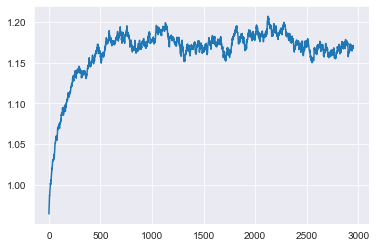

In [62]:


# rmse_list_sgld_adam = get_rmse_list(samples_sgldadam, R_test, mean_rating)

# plt.plot(rmse_list_sgld_adam)

In [65]:
# np.savetxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_adam.txt", rmse_list_sgld_adam)

rmse_list_sgld_adam = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_adam.txt")


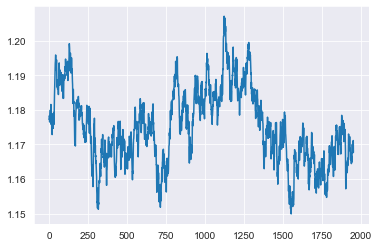

In [67]:
burnin_sgld_adam = 1000

plt.plot(rmse_list_sgld_adam[burnin_sgld_adam:])

In [68]:
samples_std_adam = []
for idx in range(6):
    samples_std_adam.append(np.std([elem[idx] for elem in samples_sgldadam[burnin_sgld_adam:]], axis=0))

list_rel_error_adam = []
for idx in range(6):
        list_rel_error_adam.append(np.linalg.norm(samples_std_adam[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))
        
mean_variance_error_adam = np.mean(list_rel_error_adam)

print(mean_variance_error_adam)


0.5785923841053545


### Summary

In [20]:
# print("Variance relative errors:\n")
# print(f"SH: {mean_variance_error_SH:.4f}")
# print(f"default: {mean_variance_error_default:.4f}")
# print(f"adam: {mean_variance_error_adam:.4f}")


print("std relative errors:\n")
print(f"SH: {std_error_sgld_SH:.4f}")
print(f"default: {std_error_sgld_default:.4f}")
print(f"adam: {std_error_sgld_adam:.4f}")


std relative errors:

SH: 0.3652
default: 1.0870
adam: 0.3747


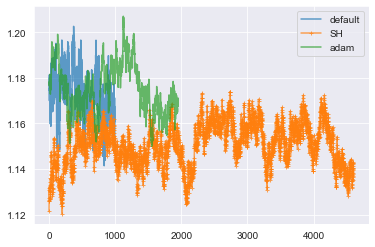

In [72]:
rmse_list_sgld_SH = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_SH.txt")
rmse_list_sgld_default = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_default.txt")
rmse_list_sgld_adam = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_adam.txt")

burnin_sgld_default = 2300
burnin_sgld_SH = 300
burnin_sgld_adam = 1000

plt.plot(rmse_list_sgld_default[burnin_sgld_default:], label="default", alpha=0.7)
plt.plot(rmse_list_sgld_SH[burnin_sgld_SH:], label="SH", alpha=0.7, marker="+", markersize=4)
plt.plot(rmse_list_sgld_adam[burnin_sgld_adam:], label="adam", alpha=0.7)

plt.legend()

# np.mean(rmse_list_sgld_default[burnin_sgld_default:])
# np.mean(rmse_list_sgld_SH[burnin_sgld_SH:])

# svrg

#### 1. SH

In [21]:
# SH
time_budget = 400.

key = random.PRNGKey(0)
# use parameters from the 1st SH chain (from list_params_sgld_10`)
dt = 10**(-4.73)
batch_size = int(0.0038*R_train.shape[0])

update_rate = 1000

samples_svrg_SH, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                               batch_size, load_PMF_MAP(), R_train, update_rate, save_rate=30)


print(f"Number of samples: {len(samples_svrg_SH)*30:,}")

Number of samples: 168,180


In [22]:
std_error_svrg_SH = get_relative_error(samples_svrg_SH)
print(std_error_svrg_SH)


0.46826196


In [12]:

rmse_list_svrg_SH = get_rmse_list(samples_svrg_SH, R_test, mean_rating)

In [19]:
# np.savetxt("outputs/PMF_uncertainty_tests/svrg/rmse_list_svrg_SH.txt", rmse_list_svrg_SH)

rmse_list_svrg_SH = np.genfromtxt("outputs/PMF_uncertainty_tests/svrg/rmse_list_svrg_SH.txt")

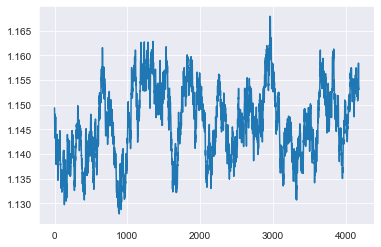

In [20]:
burnin_svrg_SH = 1500

plt.plot(rmse_list_svrg_SH[burnin_svrg_SH:])

In [17]:
samples_std_svrg_SH = []
for idx in range(6):
    samples_std_svrg_SH.append(np.std([elem[idx] for elem in samples_svrg_SH[burnin_svrg_SH:]], axis=0))

list_rel_error_svrg_SH = []
for idx in range(6):
        list_rel_error_svrg_SH.append(np.linalg.norm(samples_std_svrg_SH[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_svrg_SH = np.mean(list_rel_error_svrg_SH)

print(f"Variance estimation error for 1 SH chain: {mean_variance_error_svrg_SH:.2f}")


Variance estimation error for 1 SH chain: 0.59


#### 2. default

In [23]:
# default
time_budget = 400.

key = random.PRNGKey(0)

dt = 10**(-3.75)
batch_size = int(0.1*R_train.shape[0])
update_rate = 1000

samples_svrg_default, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                               batch_size, load_PMF_MAP(), R_train, update_rate, save_rate=30)


print(f"Number of samples: {len(samples_svrg_default)*30:,}")


Number of samples: 101,130


In [24]:
std_error_svrg_default = get_relative_error(samples_svrg_default)
print(std_error_svrg_default)


0.35239896


In [30]:
print("Variance relative errors:\n")
print(f"SH: {std_error_svrg_SH:.3f}")
print(f"default: {std_error_svrg_default:.3f}")


Variance relative errors:

SH: 0.468
default: 0.352


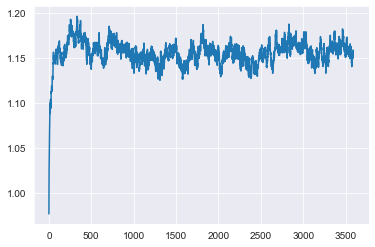

In [5]:

# rmse_list_svrg_default = get_rmse_list(samples_svrg_default, R_test, mean_rating)

# plt.plot(rmse_list_svrg_default)

In [25]:
# np.savetxt("outputs/PMF_uncertainty_tests/svrg/rmse_list_svrg_default.txt", rmse_list_svrg_default)

rmse_list_svrg_default = np.genfromtxt("outputs/PMF_uncertainty_tests/svrg/rmse_list_svrg_default.txt")


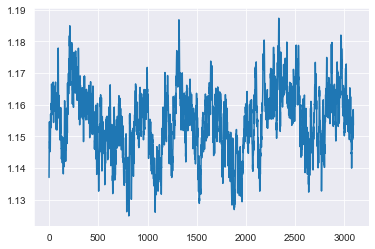

In [26]:
burnin_svrg_default = 500

plt.plot(rmse_list_svrg_default[burnin_svrg_default:])

In [27]:
samples_std_svrg_default = []
for idx in range(6):
    samples_std_svrg_default.append(np.std([elem[idx] for elem in samples_svrg_default[burnin_svrg_default:]], axis=0))

list_rel_error_svrg_default = []
for idx in range(6):
        list_rel_error_svrg_default.append(np.linalg.norm(samples_std_svrg_default[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_svrg_default = np.mean(list_rel_error_svrg_default)

print(f"Variance estimation error for the gridsearch chain: {mean_variance_error_svrg_default:.3f}")


Variance estimation error for the gridsearch chain: 0.450


In [28]:
print("Variance relative errors:\n")
print(f"SH: {mean_variance_error_svrg_SH:.4f}")
print(f"default: {mean_variance_error_svrg_default:.4f}")


Variance relative errors:

SH: 0.5891
default: 0.4499


# sghmc

#### 1. SH

In [25]:
key = random.PRNGKey(0)

# use parameters from the 1st SH chain (from list_params_sghmc_30`)
dt = 10**(-5.34)
batch_size = int(0.081*R_train.shape[0])
time_budget = 400.
L = 3

samples_sghmc_SH, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                     L, R_train, load_PMF_MAP(), save_rate=10)


print(f"Number of samples: {len(samples_sghmc_SH)*10:,}")

Iteration 1000. Time: 6 / 400.0 sec
Iteration 2000. Time: 12 / 400.0 sec
Iteration 3000. Time: 19 / 400.0 sec
Iteration 4000. Time: 26 / 400.0 sec
Iteration 5000. Time: 32 / 400.0 sec
Iteration 6000. Time: 39 / 400.0 sec
Iteration 7000. Time: 45 / 400.0 sec
Iteration 8000. Time: 52 / 400.0 sec
Iteration 9000. Time: 58 / 400.0 sec
Iteration 10000. Time: 65 / 400.0 sec
Iteration 11000. Time: 71 / 400.0 sec
Iteration 12000. Time: 78 / 400.0 sec
Iteration 13000. Time: 85 / 400.0 sec
Iteration 14000. Time: 92 / 400.0 sec
Iteration 15000. Time: 100 / 400.0 sec
Iteration 16000. Time: 106 / 400.0 sec
Iteration 17000. Time: 112 / 400.0 sec
Iteration 18000. Time: 118 / 400.0 sec
Iteration 19000. Time: 124 / 400.0 sec
Iteration 20000. Time: 130 / 400.0 sec
Iteration 21000. Time: 136 / 400.0 sec
Iteration 22000. Time: 142 / 400.0 sec
Iteration 23000. Time: 148 / 400.0 sec
Iteration 24000. Time: 154 / 400.0 sec
Iteration 25000. Time: 160 / 400.0 sec
Iteration 26000. Time: 166 / 400.0 sec
Iteration 

In [26]:
std_error_sghmc_SH = get_relative_error(samples_sghmc_SH)
print(std_error_sghmc_SH)


0.40081215


In [246]:

# rmse_list_sghmc_SH = get_rmse_list(samples_sghmc_SH, R_test, mean_rating)

In [259]:
# np.savetxt("outputs/PMF_uncertainty_tests/sghmc/rmse_list_sghmc_SH.txt", rmse_list_sghmc_SH)

rmse_list_sghmc_SH = np.genfromtxt("outputs/PMF_uncertainty_tests/sghmc/rmse_list_sghmc_SH.txt")

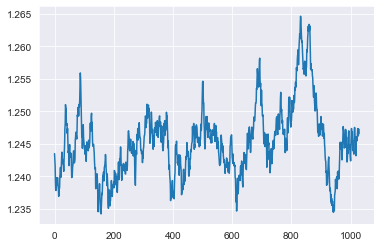

In [262]:
burnin_sghmc_SH = 2400

plt.plot(rmse_list_sghmc_SH[burnin_sghmc_SH:])

In [263]:
samples_std_sghmc_SH = []
for idx in range(6):
    samples_std_sghmc_SH.append(np.std([elem[idx] for elem in samples_sghmc_SH[burnin_sghmc_SH:]], axis=0))

list_rel_error_sghmc_SH = []
for idx in range(6):
        list_rel_error_sghmc_SH.append(np.linalg.norm(samples_std_sghmc_SH[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_sghmc_SH = np.mean(list_rel_error_sghmc_SH)

print(f"Variance estimation error for 1 SH chain: {mean_variance_error_sghmc_SH:.2f}")


Variance estimation error for 1 SH chain: 0.69


#### 2. default

In [27]:
key = random.PRNGKey(0)

dt = 10**(-5)
batch_size = int(0.1*R_train.shape[0])
time_budget = 400.
L = 26

samples_sghmc_default, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                     L, R_train, load_PMF_MAP(), save_rate=10)


print(f"Number of samples: {len(samples_sghmc_default)*10:,}")

Iteration 1000. Time: 47 / 400.0 sec
Iteration 2000. Time: 94 / 400.0 sec
Iteration 3000. Time: 142 / 400.0 sec
Iteration 4000. Time: 189 / 400.0 sec
Iteration 5000. Time: 240 / 400.0 sec
Iteration 6000. Time: 288 / 400.0 sec
Iteration 7000. Time: 335 / 400.0 sec
Iteration 8000. Time: 382 / 400.0 sec
Number of samples: 8,380


In [28]:
std_error_sghmc_default = get_relative_error(samples_sghmc_default)
print(std_error_sghmc_default)


0.556764


In [29]:
print("Variance relative errors:\n")
print(f"SH: {std_error_sghmc_SH:.3f}")
print(f"default: {std_error_sghmc_default:.3f}")


Variance relative errors:

SH: 0.401
default: 0.557


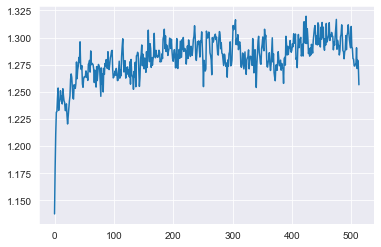

In [250]:

# rmse_list_sghmc_default = get_rmse_list(samples_sghmc_default, R_test, mean_rating)

# plt.plot(rmse_list_sghmc_default)


In [253]:
# np.savetxt("outputs/PMF_uncertainty_tests/sghmc/rmse_list_sghmc_default.txt", rmse_list_sghmc_default)

rmse_list_svrg_default = np.genfromtxt("outputs/PMF_uncertainty_tests/sghmc/rmse_list_sghmc_default.txt")


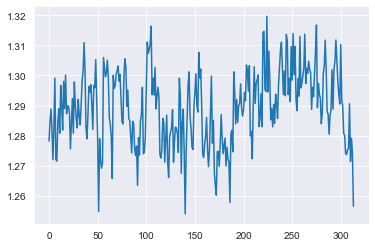

In [273]:
burnin_sghmc_default = 200

plt.plot(rmse_list_sghmc_default[burnin_sghmc_default:])

In [274]:
samples_std_sghmc_default = []
for idx in range(6):
    samples_std_sghmc_default.append(np.std([elem[idx] for elem in samples_sghmc_default[burnin_sghmc_default:]], axis=0))

list_rel_error_sghmc_default = []
for idx in range(6):
        list_rel_error_sghmc_default.append(np.linalg.norm(samples_std_sghmc_default[idx] - numpyro_stds[idx])/np.linalg.norm(numpyro_stds[idx]))

        
mean_variance_error_sghmc_default = np.mean(list_rel_error_sghmc_default)

print(f"Variance estimation error for the gridsearch chain: {mean_variance_error_sghmc_default:.2f}")


Variance estimation error for the gridsearch chain: 0.81


In [277]:
print("Variance relative errors:\n")
print(f"SH: {mean_variance_error_sghmc_SH:.3f}")
print(f"default: {mean_variance_error_sghmc_default:.3f}")


Variance relative errors:

SH: 0.689
default: 0.810


## accuracy plots

In [31]:

# sgld
rmse_list_sgld_SH = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_SH.txt")
rmse_list_sgld_default = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_default.txt")
rmse_list_sgld_adam = np.genfromtxt("outputs/PMF_uncertainty_tests/sgld/rmse_list_sgld_adam.txt")

# svrg
rmse_list_svrg_SH = np.genfromtxt("outputs/PMF_uncertainty_tests/svrg/rmse_list_svrg_SH.txt")
rmse_list_svrg_default = np.genfromtxt("outputs/PMF_uncertainty_tests/svrg/rmse_list_svrg_default.txt")

# sghmc
rmse_list_sghmc_SH = np.genfromtxt("outputs/PMF_uncertainty_tests/sghmc/rmse_list_sghmc_SH.txt")
rmse_list_sghmc_default = np.genfromtxt("outputs/PMF_uncertainty_tests/sghmc/rmse_list_sghmc_default.txt")


# =====
# burn-in
burnin_sgld_SH = 300
burnin_sgld_default = 2300
burnin_sgld_adam = 1000

burnin_svrg_SH = 1000
burnin_svrg_default = 150

burnin_sghmc_SH = 2400
burnin_sghmc_default = 200

In [39]:
mean_RMSE_sgld_SH = np.mean(rmse_list_sgld_SH[burnin_sgld_SH:])
mean_RMSE_sgld_default = np.mean(rmse_list_sgld_default[burnin_sgld_default:])
mean_RMSE_sgld_adam = np.mean(rmse_list_sgld_adam[burnin_sgld_adam:])

mean_RMSE_svrg_SH = np.mean(rmse_list_svrg_SH[burnin_svrg_SH:])
mean_RMSE_svrg_default = np.mean(rmse_list_svrg_default[burnin_svrg_default:])

mean_RMSE_sghmc_SH = np.mean(rmse_list_sghmc_SH[burnin_sghmc_SH:])
mean_RMSE_sghmc_default = np.mean(rmse_list_sghmc_default[burnin_sghmc_default:])


print("RMSE (after removing burn-in):\n")

print("SGLD:")
print(f"SH: {mean_RMSE_sgld_SH:.3f}")
print(f"default: {mean_RMSE_sgld_default:.3f}")
print(f"adam: {mean_RMSE_sgld_adam:.3f}")

print("\nSVRG:")
print(f"SH: {mean_RMSE_svrg_SH:.3f}")
print(f"default: {mean_RMSE_svrg_default:.3f}")

print("\nSGHMC:")
print(f"SH: {mean_RMSE_sghmc_SH:.3f}")
print(f"default: {mean_RMSE_sghmc_default:.3f}")

RMSE (after removing burn-in):

SGLD:
SH: 1.151
default: 1.172
adam: 1.175

SVRG:
SH: 1.146
default: 1.156

SGHMC:
SH: 1.245
default: 1.289


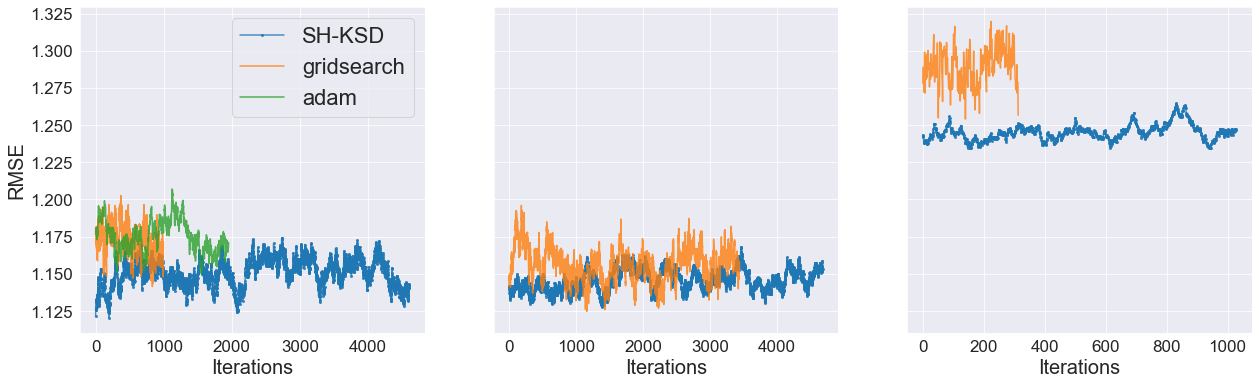

In [34]:

plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6), sharey=True)


ax[0].plot(rmse_list_sgld_SH[burnin_sgld_SH:], alpha=.8, label="SH-KSD", marker="o", markersize=2)
ax[0].plot(rmse_list_sgld_default[burnin_sgld_default:], alpha=.8, label="gridsearch")
ax[0].plot(rmse_list_sgld_adam[burnin_sgld_adam:], alpha=.8, label="adam")

ax[1].plot(rmse_list_svrg_SH[burnin_svrg_SH:], alpha=.8, label="SH-KSD", marker="o", markersize=2)
ax[1].plot(rmse_list_svrg_default[burnin_svrg_default:], alpha=.8, label="gridsearch")

ax[2].plot(rmse_list_sghmc_SH[burnin_sghmc_SH:], alpha=.8, label="SH-KSD", marker="o", markersize=2)
ax[2].plot(rmse_list_sghmc_default[burnin_sghmc_default:], alpha=.8, label="gridsearch")

ax[0].set_ylabel("RMSE", size=20)
ax[0].set_xlabel("Iterations", size=20)
ax[1].set_xlabel("Iterations", size=20)
ax[2].set_xlabel("Iterations", size=20)
ax[0].legend(fontsize=22)

# plt.savefig("images/PMF_RMSE_plots.png")